В качестве примера мы подготовим модель предсказания стоимости жилья. Далее эту модель мы сохраним в pickle файл и развернем в клиент-серверном приложении.

Исходные данные для обучения модели были взяты с kaggle.com

# Импорты

In [94]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols

from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

# Подготовка исходных данных

В данном разделе мы проанализируем исходные данные и подготовим их для дальнейшего обучения нашей модели.

## Загружаем данные

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print("Размер обучающей выборки:", train_df.shape)
print("Размер тестовой выборки:", test_df.shape)

Размер обучающей выборки: (1460, 81)
Размер тестовой выборки: (1459, 80)


Опишем переменные, которые нам пригодятся в дальнейшем.

In [3]:
y_train = train_df['SalePrice']
test_id = test_df['Id']

ntrain = train_df.shape[0]
ntest = test_df.shape[0]

Объединим обучающую и тестовую выборки, чтобы изучить данные, а также заполнить недостающие значения.

In [4]:
all_data = pd.concat((train_df, test_df), sort=True).reset_index(drop=True)
all_data['Dataset'] = np.repeat(['Train', 'Test'], [ntrain, ntest], axis=0)
all_data = all_data.drop('Id', axis='columns')

display(all_data.head())
print(all_data.shape)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Dataset
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,0,Pave,8,856.0,AllPub,0,2003,2003,2008,Train
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,0,Pave,6,1262.0,AllPub,298,1976,1976,2007,Train
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,0,Pave,6,920.0,AllPub,0,2001,2002,2008,Train
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,0,Pave,7,756.0,AllPub,0,1915,1970,2006,Train
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,0,Pave,9,1145.0,AllPub,192,2000,2000,2008,Train


(2919, 81)


## Изучим переменные

### Целевая переменная: SalePrice

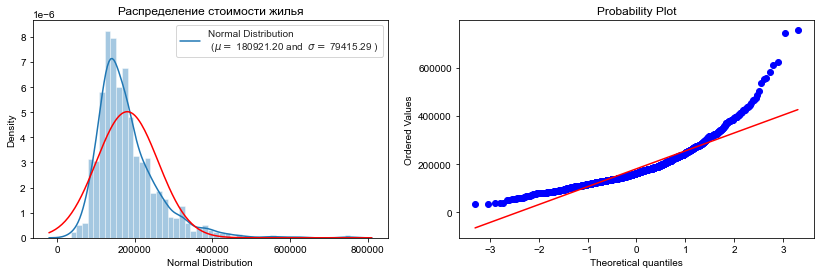

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.set_style('whitegrid')
sns.distplot(
    all_data['SalePrice'][~all_data['SalePrice'].isnull()], axlabel="Normal Distribution", 
    fit=st.norm, fit_kws={"color":"red"}, ax=ax[0])
ax[0].set_title('Распределение стоимости жилья')
(mu, sigma) = st.norm.fit(train_df['SalePrice'])
ax[0].legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fancybox=True)

st.probplot(all_data['SalePrice'][~all_data['SalePrice'].isnull()], plot=ax[1])
fig.show()

По гистограмме похоже, что данные распределены нормально. Рассчитаем ассиметрию и эксцесс для данного распределения данных.

In [6]:
print('Ассиметрия:\t{:.2f}'.format(train_df['SalePrice'].skew()))
print('Эксцесс:\t{:.2f}'.format(train_df['SalePrice'].kurt()))

Ассиметрия:	1.88
Эксцесс:	6.54


Важно отметить:
- если ассиметрия [-0.5, 0.5], то данные вполне симметричны;
- если асимметрия находится в диапазоне [-1, 0.5] или [0.5, 1], то данные умеренно ассиметричны;
- если ассиметрия меньше -1 или больше 1, то данные сильно ассиметричны

По поводу ексцесса можно отметить следующее:
- ексцесс определяет вес хвостов распределения;
- невысокий эксцесс в данных показывает отсутствие выбросов, в то время как высокий ексцесс показывает наличие весомых выбросов в данных 

Теперь посмотрим, что будет, если использовать логарифм стоимости жилья.

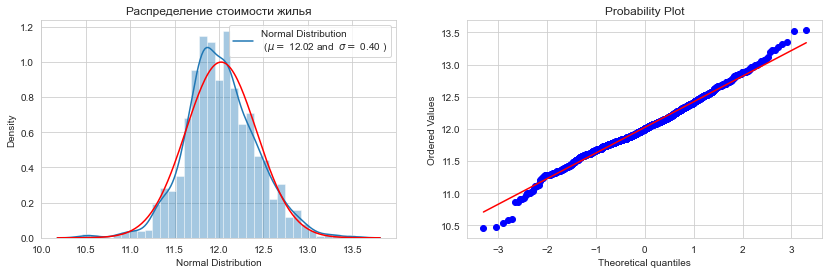

In [7]:
all_data['SalePrice'] = np.log1p(all_data['SalePrice'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.set_style('whitegrid')
sns.distplot(
    all_data['SalePrice'][~all_data['SalePrice'].isnull()], axlabel="Normal Distribution", 
    fit=st.norm, fit_kws={"color":"red"}, ax=ax[0])
ax[0].set_title('Распределение стоимости жилья')
(mu, sigma) = st.norm.fit(np.log1p(train_df['SalePrice']))
ax[0].legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fancybox=True)

st.probplot(all_data['SalePrice'][~all_data['SalePrice'].isnull()], plot=ax[1])
fig.show()

In [8]:
print('Ассиметрия:\t{:.2f}'.format(all_data['SalePrice'].skew()))
print('Эксцесс:\t{:.2f}'.format(all_data['SalePrice'].kurt()))

Ассиметрия:	0.12
Эксцесс:	0.81


Вывод: логично предсказывать логарифм стоимости жилья вместо его абсолютного значения в случае использования линейной модели предсказания стоимости. Ибо хвосты будут симметричными и не слишком тяжелыми, и поэтому выбросы на модель буду не так сильно влиять.

## Заполним пропуски в данных

In [9]:
missing_values = pd.DataFrame(data=all_data.isnull().sum().sort_values(ascending=False), columns=['Quantity'])
missing_values['Percentage'] = missing_values['Quantity'] / all_data.shape[0]
missing_values = missing_values.drop(missing_values[missing_values['Quantity'] == 0].index, axis='rows')
missing_values = missing_values.drop('SalePrice', axis='rows')

display(missing_values)

,Quantity,Percentage
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471
GarageCond,159,0.054471
GarageQual,159,0.054471


### Отсутствующие значения, соответствующие отсутствию определенного свойства

**PoolQC** - качество бассейна. Отсутствие данных говорит о том, что бассейна нет. Также есть еще одно свойство объекта - площадь бассейна - PoolArea. Если площадь указана 0, то данных в колонке, характеризующей качество бассейна нет.

In [10]:
all_data['PoolQC'] = all_data['PoolQC'].replace(np.nan, 'None')

**MiscFeature** - указаны дополнительные свойства объектов. Пропуски означают что таких дополнительных свойств нет.

In [11]:
all_data['MiscFeature'] = all_data['MiscFeature'].replace(np.nan, 'None')

**Alley**. Пропуски в данных означают, что нет доступа к аллее.

In [12]:
all_data['Alley'] = all_data['Alley'].replace(np.nan, 'None')

**Fence**. Пропуски в данных означают, что забор отсутствует.

In [13]:
all_data['Fence'] = all_data['Fence'].replace(np.nan, 'None')

**FireplaceQu** - колонка, характеризующая качество камина. В данных также присутствует колонка, характеризующая количество каминов в доме. В случае, когда количество каминов указано 0, то в колонке, характеризующей качество каминов - NaN. В остальных случаях обязательно указано значение.

In [14]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].replace(np.nan, 'None')

**GarageType**, **GarageFinish**, **GarageQual** и **GarageCond** - свойства, характеризующие гараж в доме. Когда гараж в доме отсутствует, то значения в данных колонках - NaN.

In [15]:
garage_cat_features = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
all_data[garage_cat_features] = all_data[garage_cat_features].replace(np.nan, 'None')

**GarageYrBlt**, **GarageCars**, **GarageArea** - числовые параметры, характеризующие гараж в доме. Пропуски заполним 0.

In [16]:
garage_num_features = ['GarageYrBlt', 'GarageCars', 'GarageArea']
all_data[garage_num_features] = all_data[garage_num_features].replace(np.nan, 0)

**BsmtQual**, **BsmtCond**, **BsmtExposure**, **BsmtFinType1** и **BsmtFinType2** - вероятней всего, пропуски данных по причине отсутствия подвала в доме. Заменим на 'None'.

In [17]:
basement_cat_features = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
all_data[basement_cat_features] = all_data[basement_cat_features].replace(np.nan, 'None')

**BsmtFinSF1**, **BsmtFinSF2**, **BsmtUnfSF**, **TotalBsmtSF**, **BsmtFullBath** и **BsmtHalfBath** - вероятней всего, пропуски в данных по причине отсутствия подвала в доме. Заменим пропуски в этих колонках на 0.

In [18]:
basement_num_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
all_data[basement_num_features] = all_data[basement_num_features].replace(np.nan, 0)

**MasVnrType** и **MasVnrArea** - отсутствие данных вероятней всего по причине отсутствия каменной кладки на облицовке. Заменим на 'None' и на 0.

In [19]:
all_data['MasVnrArea'] = all_data['MasVnrArea'].replace(np.nan, 0)
all_data['MasVnrType'] = all_data['MasVnrType'].replace(np.nan, 'None')

**Functional** - заменим на "typical".

In [20]:
all_data['Functional'] = all_data['Functional'].replace(np.nan, 'Typ')

### Заполнение пропусков наиболее частым значением

Для некоторых категориальных колонок заполним пропуски наиболее часто встречаемыми значениями. Преимущества - делается быстро и не добавляет дисперсии нашим данным.

In [21]:
def plot_features(data: pd.Series) -> pd.Series:
    print('Количество пропусщенных значений: {}'.format(data.isna().sum()))
    
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

    
def fill_missing_values(data: pd.Series) -> pd.Series:
    most_fv = data.mode()[0]
    print('Наиболее часто встречаемое значение: {}'.format(most_fv))
    return data.replace(np.nan, most_fv)

**MSZoning**

Количество пропусщенных значений: 4


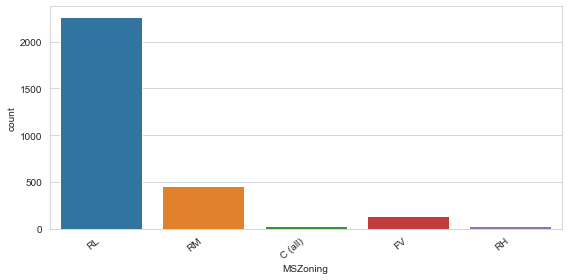

Наиболее часто встречаемое значение: RL


In [22]:
plot_features(data=all_data['MSZoning'])
all_data['MSZoning'] = fill_missing_values(data=all_data['MSZoning'])

**Utilities**

In [23]:
print('Обучающая выборка:')
display(all_data[all_data['Dataset'] == 'Train']['Utilities'].value_counts(dropna=False))
print('\nТестовая выборка:')
display(all_data[all_data['Dataset'] == 'Test']['Utilities'].value_counts(dropna=False))

Обучающая выборка:


AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


Тестовая выборка:


AllPub    1457
NaN          2
Name: Utilities, dtype: int64

Параметр NoSeWa содержится только в обучающей выборке. Поэтому для предсказания в тестовой этот параметр никакой роли не играет и его можно смело удалить.

In [24]:
all_data = all_data.drop('Utilities', axis=1)

**Electrical**

Количество пропусщенных значений: 1


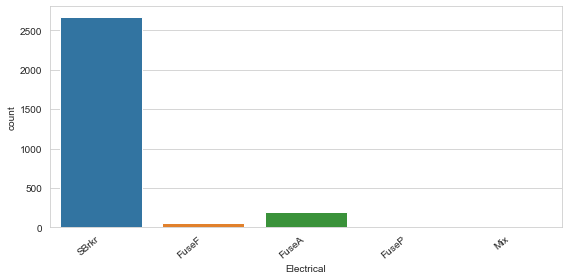

Наиболее часто встречаемое значение: SBrkr


In [25]:
plot_features(data=all_data['Electrical'])
all_data['Electrical'] = fill_missing_values(data=all_data['Electrical'])

**Exterior1st** и **Exterior2nd**

Количество пропусщенных значений: 1


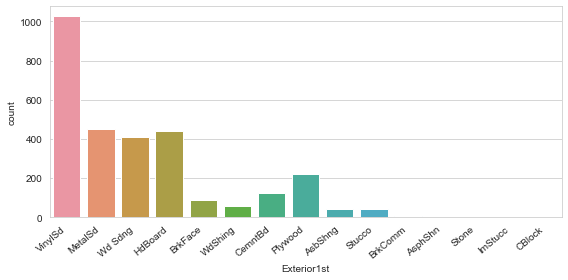

Наиболее часто встречаемое значение: VinylSd


In [26]:
plot_features(data=all_data['Exterior1st'])
all_data['Exterior1st'] = fill_missing_values(data=all_data['Exterior1st'])

Количество пропусщенных значений: 1


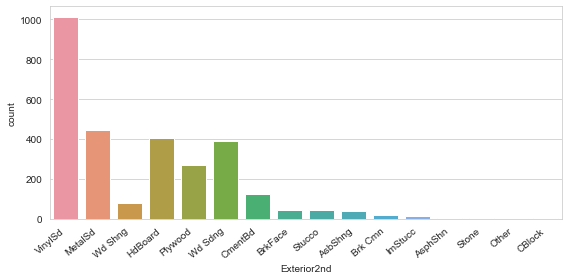

Наиболее часто встречаемое значение: VinylSd


In [27]:
plot_features(data=all_data['Exterior2nd'])
all_data['Exterior2nd'] = fill_missing_values(data=all_data['Exterior2nd'])

**KitchenQual**

Количество пропусщенных значений: 1


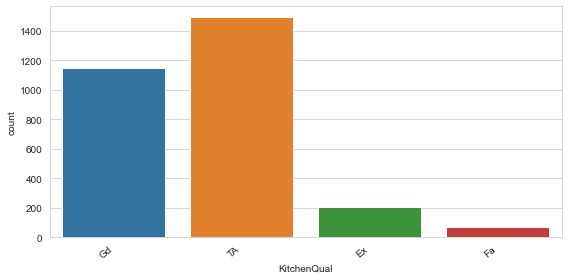

Наиболее часто встречаемое значение: TA


In [28]:
plot_features(data=all_data['KitchenQual'])
all_data['KitchenQual'] = fill_missing_values(data=all_data['KitchenQual'])

**SaleType**

Количество пропусщенных значений: 1


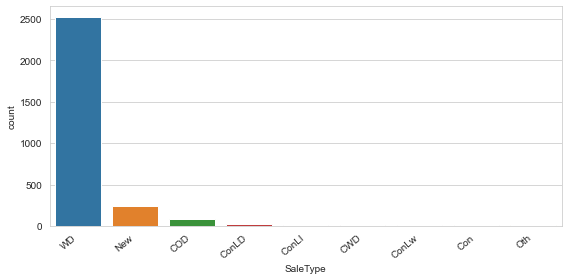

Наиболее часто встречаемое значение: WD


In [29]:
plot_features(data=all_data['SaleType'])
all_data['SaleType'] = fill_missing_values(data=all_data['SaleType'])

Посмотрим, в каких колонках остались пропуски.

In [30]:
missing_values = pd.DataFrame(data=all_data.isnull().sum().sort_values(ascending=False), columns=['Quantity'])
missing_values['Percentage'] = missing_values['Quantity'] / all_data.shape[0]
missing_values = missing_values.drop(missing_values[missing_values['Quantity'] == 0].index, axis='rows')

display(missing_values)

,Quantity,Percentage
SalePrice,1459,0.499829
LotFrontage,486,0.166495


## Features engineering

Для уменьшения количества параметров объектов и улучшения качества, решено использовать объединение некоторых параметров объектов.

**Condition1** и **Condition2** - близость к различным объектам (дорогам и паркам, к примеру) и второе, если более одного объекта.

In [31]:
all_data['MixedConditions'] = list(map(
    lambda ext: ' - '.join(set(ext)), zip(all_data['Condition1'], all_data['Condition2'])))
all_data = all_data.drop(['Condition1', 'Condition2'], axis='columns')

**Exterior1st** и **Exterior2nd** - наружное покрытие дома и наружное покрытие дома если более одного. По сути, это одно и свойство, которое следовало бы объединить в одно.

In [32]:
# унифицируем тип отделки. Например Wd Shng и WdShing - одно и то же
exterior_cols = ['Exterior1st', 'Exterior2nd']
all_data[exterior_cols] = all_data[exterior_cols].replace('Wd Shng', 'WdShing')
all_data[exterior_cols] = all_data[exterior_cols].replace('Brk Cmn', 'BrkComm')

In [33]:
all_data['MixedExterior'] = list(map(
    lambda ext: ' - '.join(set(ext)), zip(all_data['Exterior1st'], all_data['Exterior2nd'])))
all_data = all_data.drop(['Exterior1st', 'Exterior2nd'], axis='columns')

**Общая площадь дома**

Поскольку общая жилая площадь дома не указана, а это является очень важным атрибутом, то мы объединим площадь подвала, первого и второго этажей в общую площадь дома в качестве нового свойства объектов.

In [34]:
sf_cols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
all_data['TotalSF'] = all_data[sf_cols].sum(axis='columns')

Посчитаем корреляцию между колонками, характеризующими площадь жилья, и целевой переменной.

In [35]:
sf_df = all_data[sf_cols + ['TotalSF', 'SalePrice']].drop(
    all_data[all_data['SalePrice'].isnull()].index, axis='rows')
sf_corr = {col_name: np.corrcoef(col, sf_df['SalePrice'])[1, 0] for col_name, col in sf_df.drop(
    'SalePrice', axis='columns').iteritems()}
sf_corr = pd.DataFrame(data=sf_corr, index=['SalePrice correlation'])

display(sf_corr)

,TotalBsmtSF,1stFlrSF,2ndFlrSF,TotalSF
SalePrice correlation,0.612134,0.596981,0.3193,0.777297


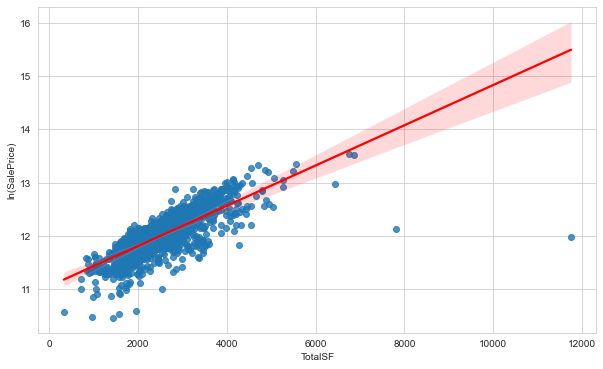

In [36]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(all_data['TotalSF'], all_data['SalePrice'], line_kws={'color': 'red'})
ax.set(ylabel='ln(SalePrice)')
plt.show()

Наблюдается сильная корреляция между SalePrice и общей площадью дома. Присутствует два выброса, которые необходимо удалить.

**Общее количество ванных комнат**

Всего в датасете присутствует 4 переменные, отвечающие за ванные комнаты (количество тех или иных ванных комнат):
- BsmtFullBath
- BsmtHalfBath 
- FullBath 
- HalfBath

Full bath - полноценная ванная комната. Half bath - гостевая ванная комната (или дамская комната), имеет только раковину и туалет. По отдельности эти переменные особой роли не играют, но объединив их в одну, мы получим неплохую фичу.

In [37]:
all_data['TotalBath'] = all_data[['BsmtFullBath', 'FullBath']].sum(axis='columns') + \
                        all_data[['BsmtHalfBath', 'HalfBath']].sum(axis='columns')*0.5

Взглянем на корреляцию с целевой переменной

In [38]:
bath_df = all_data[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotalBath', 'SalePrice']].drop(
    all_data[all_data['SalePrice'].isnull()].index, axis='rows')
bath_corr = {col_name: np.corrcoef(col, bath_df['SalePrice'])[1, 0] for col_name, col in bath_df.drop(
    'SalePrice', axis='columns').iteritems()}
bath_corr = pd.DataFrame(data=bath_corr, index=['SalePrice correlation'])

display(bath_corr)

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotalBath
SalePrice correlation,0.236224,-0.005149,0.594771,0.313982,0.673011


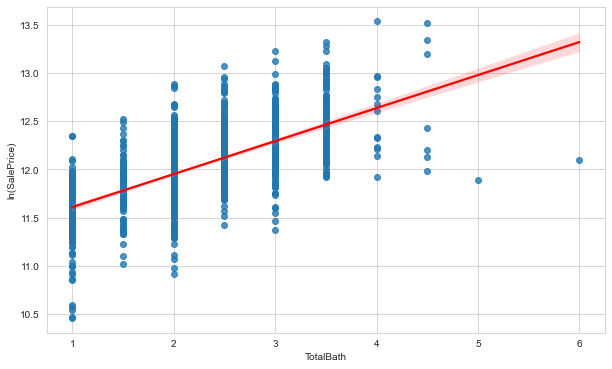

In [39]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(all_data['TotalBath'], all_data['SalePrice'], line_kws={'color': 'red'})
ax.set(ylabel='ln(SalePrice)')
plt.show()

И действительно, мы видим линейную зависимость между общим количеством ванных комнат и стоимостью жилья.

**Neighborhood**

Данная переменная говорит о расположении дома в городе. Для уменьшения количества категорий, воспользуемся кластеризацией, а именно K-Means. Оптимальное количество кластеров выберем с помощью elbow метода. Согласно этому методу, мы вибираем такое количество кластеров, при котором дальнейшее увеличение количества кластеров не приводит к значительному уменьшению ошибки.

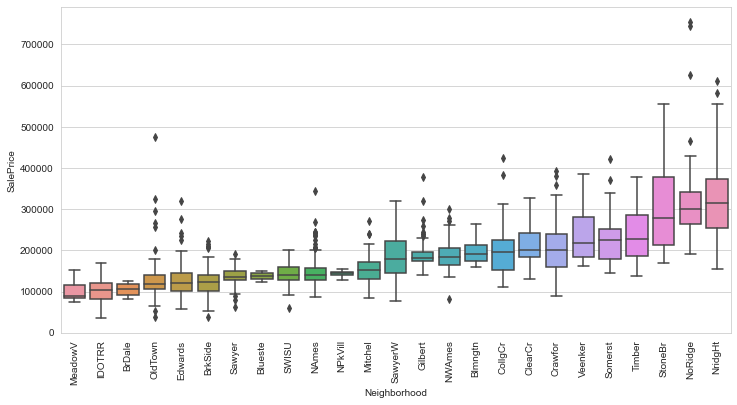

In [40]:
data = all_data[~all_data['SalePrice'].isnull()]
data['SalePrice'] = np.exp(data['SalePrice'])
grouped_data = data.loc[:, ['Neighborhood', 'SalePrice']].groupby(['Neighborhood']).median()
grouped_data = grouped_data.sort_values(by='SalePrice')

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x='Neighborhood', y='SalePrice', data=data, order=grouped_data.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.show()

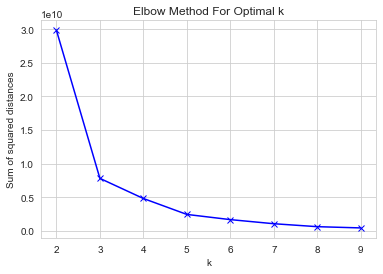

In [41]:
distances = list()
n_clust = range(2, 10)
for k in n_clust:
    km = KMeans(n_clusters=k).fit(grouped_data)
    distances.append(km.inertia_)
    

plt.plot(n_clust, distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Оптимальное количество кластеров - 3. Именно в точке k = 3 происходит значительный излом графика. Дальнейший рост количества не приводит к существенному улучшению результата.

Посмотрим, как выглядят разбитые на кластера значения.

In [42]:
km = KMeans(n_clusters=3).fit(grouped_data)
grouped_data['Cluster'] = km.labels_
grouped_data['Color'] = grouped_data['Cluster'].replace(
    dict(zip(range(3), plt.rcParams['axes.prop_cycle'].by_key()['color'][:3])))

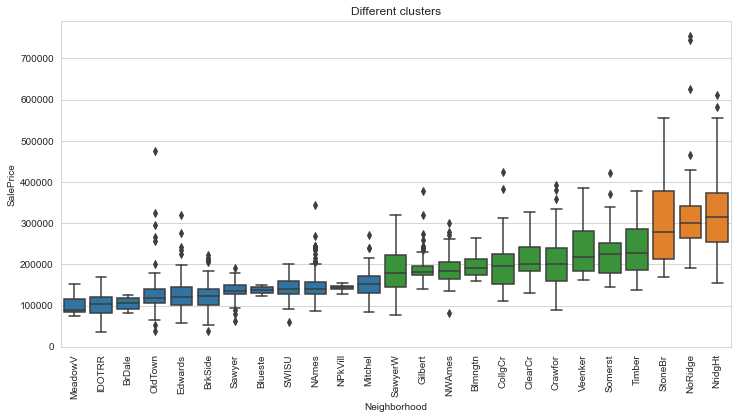

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x='Neighborhood', y='SalePrice', data=data, order=grouped_data.index, 
                 palette=dict(zip(grouped_data.index, grouped_data['Color'])))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Different clusters')
fig.show()

Добавим дополнительную фичу в наш датасет - Neighborhood_Clast

In [44]:
neighborhood_dict = dict(zip(grouped_data.index, grouped_data['Cluster']))
all_data['Neighborhood_Class'] = all_data['Neighborhood'].replace(neighborhood_dict)

## Заполнение пропусков в LotFrontage

In [45]:
print('Всего пропусков в колонке LotFrontage:\t\t{}'.format(all_data['LotFrontage'].isna().sum()))
print('Процент пропусков в колонке LotFrontage:\t{:.2f}'.format(all_data['LotFrontage'].isna().mean()))

Всего пропусков в колонке LotFrontage:		486
Процент пропусков в колонке LotFrontage:	0.17


Используем SVM imputer для заполнения пропусков в данной колонке. Trainset - значения без пропусков, testset - значения с пропусками.

In [46]:
train_lf = all_data[~all_data['LotFrontage'].isnull()]
test_lf = all_data[all_data['LotFrontage'].isnull()]

print('Размер обучающей выборки для LotFrontage:\t{}'.format(train_lf.shape))
print('Размер тестовой выборки для LotFrontage:\t{}'.format(test_lf.shape))
display(all_data['LotFrontage'].describe().to_frame().transpose())

Размер обучающей выборки для LotFrontage:	(2433, 81)
Размер тестовой выборки для LotFrontage:	(486, 81)


,count,mean,std,min,25%,50%,75%,max
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0


Выведем boxplot и распределение для LotFrontage

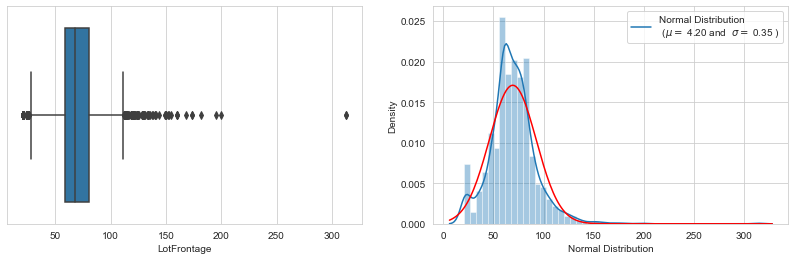

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.boxplot(train_lf['LotFrontage'], ax=ax[0])
sns.set_style('whitegrid')
sns.distplot(
    train_lf['LotFrontage'], axlabel="Normal Distribution", 
    fit=st.norm, fit_kws={"color":"red"}, ax=ax[1])
(mu, sigma) = st.norm.fit(np.log1p(train_lf['LotFrontage']))
ax[1].legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fancybox=True)
fig.show()

Что можно сказать по этим графикам:
- длинный хвост у больших значений LotFrontage
- на графике распределения виден пик для небольших значений LotFrontage

Прежде, чем переходить к обучению модели для заполнения пропусков, избавимся от выбросов.

In [48]:
def outlier_detection(data):
    q_1, q_3 = np.percentile(data, [25,75])
    iqr = q_3 - q_1
    lower_cutoff = q_1 - (iqr * 1.5)
    upper_cutoff = q_3 + (iqr * 1.5)
    outliers = (data > q_3 + 1.5*iqr) | (data < q_1 - 1.5*iqr)
    return outliers

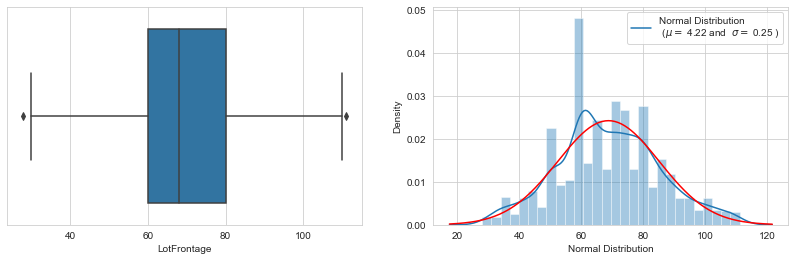

In [49]:
train_lf_no_outliers = train_lf[~outlier_detection(train_lf['LotFrontage'])]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.boxplot(train_lf_no_outliers['LotFrontage'], ax=ax[0])
sns.set_style('whitegrid')
sns.distplot(
    train_lf_no_outliers['LotFrontage'], axlabel="Normal Distribution", 
    fit=st.norm, fit_kws={"color":"red"}, ax=ax[1])
(mu, sigma) = st.norm.fit(np.log1p(train_lf_no_outliers['LotFrontage']))
ax[1].legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fancybox=True)
fig.show()

Теперь наши данные не имеют выбросов и можно переходить к следующим шагам.

Теперь мы можем исследовать взаимосвязь между целевой переменной LotFrontage и другими переменными. Чтобы подтвердить взаимосвязь между этими ключевыми характеристиками, мы проведем тест ANOVA (дисперсионный анализ) для определения статистической значимости (в данном случае p < 0,01).

Используя ANOVA III, мы будем уверены, что переменные, перечисленные в таблице ниже, коррелируют с LotFrontage.
- Примечание: переменные, начинающиеся с числа (1stFlrSF, 2ndFlrSF и 3SsnPorch), вызовут синтаксическую ошибку при вводе формулы ols. Преобразуем их.

In [50]:
temp_train = train_lf_no_outliers.copy()
cols_to_fix = {col: 'X' + col for col in temp_train.columns if col[0].isdigit()}
temp_train = temp_train.rename(columns=cols_to_fix)

mod = ols('LotFrontage ~ ' + ' + '.join(
    temp_train.drop(['Dataset', 'LotFrontage', 'SalePrice'], axis='columns').columns), data=temp_train).fit()
aov_table = sm.stats.anova_lm(mod, typ=3)
display(aov_table[aov_table['PR(>F)'] < 0.01].sort_values(by='PR(>F)', ascending=True))

,sum_sq,df,F,PR(>F)
LotConfig,43826.006397,4.0,120.691495,4.262851e-92
BldgType,20959.928754,4.0,57.721096,4.326737e-46
Neighborhood,15030.360263,23.0,7.198571,1.858603e-22
LotArea,5396.720645,1.0,59.447651,1.987883e-14
GarageType,4555.013797,6.0,8.362636,5.676161e-09
LotShape,2827.769965,3.0,10.383113,8.875463e-07
HouseStyle,3643.287017,7.0,5.733240,1.389389e-06
MixedExterior,11333.526460,63.0,1.981661,9.592967e-06
RoofMatl,2523.113983,5.0,5.558679,4.321642e-05
MixedConditions,4358.660898,17.0,2.824288,9.837647e-05


Переходим к подготовке данных и обучению модели

In [51]:
X = train_lf_no_outliers[aov_table[aov_table['PR(>F)'] < 0.01].index]
y = train_lf_no_outliers['LotFrontage']

X = pd.get_dummies(X)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = svm.SVR(kernel='rbf', C=100, gamma=0.001)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print('MAE:  {}'.format(mean_absolute_error(y_test, y_hat)))

MAE:  6.525287125969574


Используем эту модель для предсказания пропущенных значений в LotFrontage

In [53]:
model_data = train_lf_no_outliers.copy()
model_data = model_data.append(test_lf)
y = model_data['LotFrontage']
model_data = model_data[aov_table[aov_table['PR(>F)'] < 0.01].index]

model_data = pd.get_dummies(model_data)
model_X_train = model_data[~y.isnull()]
model_X_test = model_data[y.isnull()]
model_y_train = y[~y.isnull()]

scaler = StandardScaler().fit(model_X_train)
model_X_train = scaler.transform(model_X_train)
model_X_test = scaler.transform(model_X_test)

clf = svm.SVR(kernel='rbf', C=100, gamma=0.001)
clf.fit(model_X_train, model_y_train)
lf_preds = clf.predict(model_X_test)

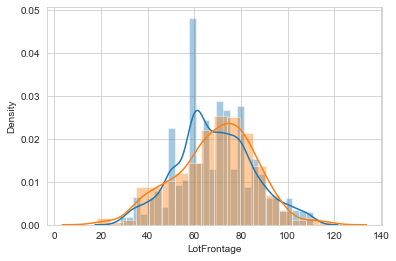

In [54]:
sns.distplot(model_y_train)
sns.distplot(lf_preds);

Добавим предсказанные значения в исходный датасет.

In [55]:
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = lf_preds

## Подготовка датасета для обучения модели

### Удаление выбросов

Глубокое изучение фичей решено не использовать, а удалить только два выброса, найденных в переменной TotalSF.

In [56]:
objects_to_remove = all_data[all_data['Dataset'] == 'Train']['TotalSF'].nlargest(2).index
all_data = all_data.drop(objects_to_remove, axis='rows')

### Корреляция между числовыми переменными

В случае корреляции свойств объектов, можно пойти двумя путями:
- удаление колонок, имеющих высокую корреляцию
- использование регуляризации

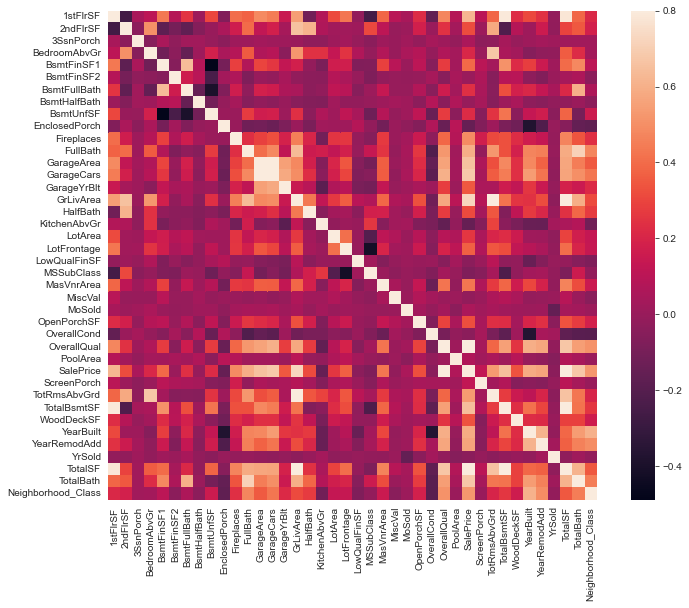

In [57]:
corrmat = all_data.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, ax=ax);

Что можно сказать по этиму графику:
- GarageArea неплохо коррелирует с количеством машин, которые можно поставить в гараж - GarageCars;
- TotalSF (суммарная площадь дома) коррелирует с GrLivArea (площадь дома над землей) - в большей степени, и c TotalBsmtDF (площадь подвального помещения) - в меньшей степени;
- также GrLivArea (площадь дома над землей) хорошо коррелирует с TotRmsAbvGrd (количество комнат над землей).

### Label encoding

Некоторые переменные представлены в виде числовых значений.Закодируем их с помощью label encoding.

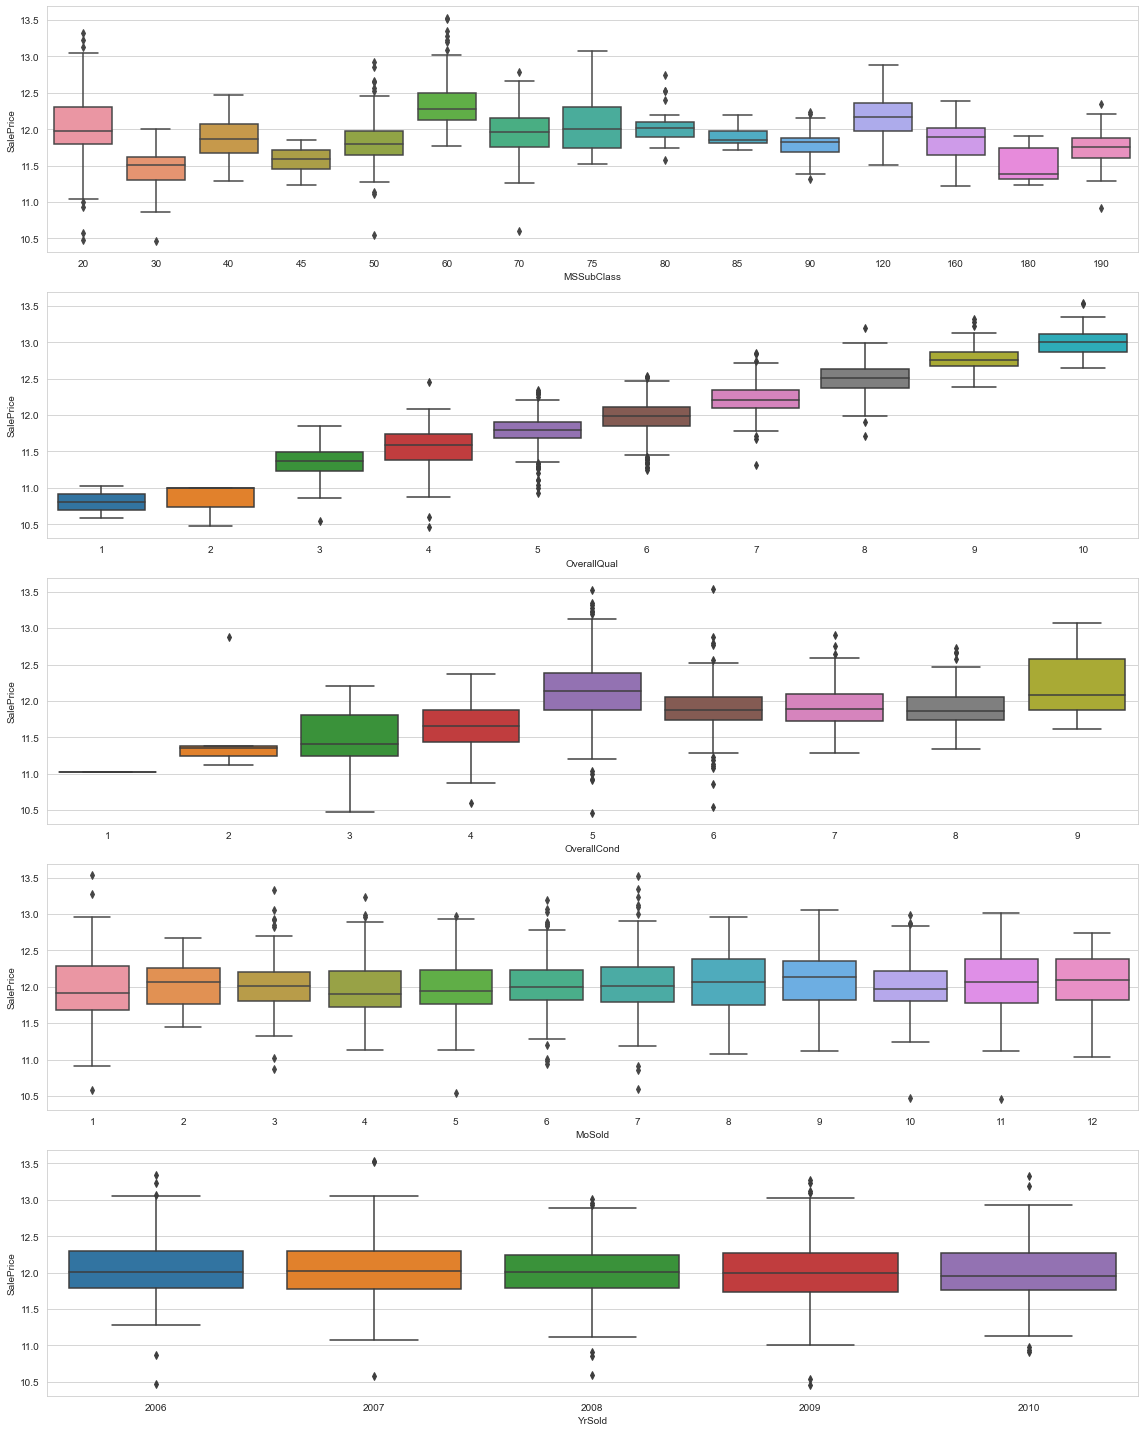

In [58]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(16, 20))
sns.boxplot(x='MSSubClass', y='SalePrice', data=all_data[all_data['Dataset'] == 'Train'], ax=ax[0])
sns.boxplot(x='OverallQual', y='SalePrice', data=all_data[all_data['Dataset'] == 'Train'], ax=ax[1])
sns.boxplot(x='OverallCond', y='SalePrice', data=all_data[all_data['Dataset'] == 'Train'], ax=ax[2])
sns.boxplot(x='MoSold', y='SalePrice', data=all_data[all_data['Dataset'] == 'Train'], ax=ax[3])
sns.boxplot(x='YrSold', y='SalePrice', data=all_data[all_data['Dataset'] == 'Train'], ax=ax[4])
fig.tight_layout()
fig.show();

Выше, на примере некоторых числовых фичей которые по сути дела являются категориальными, можно отследить связь с целевой переменной. Такие фичи, в случае кодирования с помощью label encoding, логично закодировать "линейно" с целевой переменной. Т.е. чтобы большему значению фичи соответствовали большие значения целевой переменной (медианы). Так качество на линейной модели будет более высоким.

In [59]:
class CustomLabelEncoder:
    def __init__(self):
        self.replace_values = dict()
    
    def fit(self, feature: pd.Series, target: pd.Series) -> None:
        data = pd.DataFrame(data={'Feature': feature, 'Target': target})
        grouped_data = data.groupby(by='Feature').median()
        grouped_data = grouped_data.interpolate(method='linear', limit_direction='both')
        grouped_data = grouped_data.sort_values(by='Target', ascending=True)
        self.replace_values = dict(zip(grouped_data.index, range(len(grouped_data.index))))
        return
    
    def transform(self, data: pd.Series) -> None:
        data.replace(self.replace_values, inplace=True)
        return
    
    def fit_transform(self, feature: pd.Series, target: pd.Series) -> None:
        self.fit(feature=feature, target=target)
        self.transform(data=feature)
        return

Категориальные фичи закодируем с помощью метода выше (в том числе и те, которые числовые, но по сути являются категориальными).

In [60]:
encoder = CustomLabelEncoder()
label_enc_features = [
    'BedroomAbvGr', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu',
    'Fireplaces', 'FullBath', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageYrBlt',
    'HalfBath', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'MSSubClass', 'MoSold', 'OverallCond',
    'OverallQual', 'PoolQC', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'Neighborhood_Class']
for feature in label_enc_features:
    encoder.fit_transform(feature=all_data[feature], target=all_data['SalePrice'])

### Преобразование числовых данных

В числовых данных избавимся от ассиметрии (насколько это возможно) и нормализуем их с помощью MinMaxScaler

In [61]:
numeric_features = all_data.columns[(all_data.dtypes != 'object') & 
                                    (~all_data.columns.isin(label_enc_features + ['SalePrice']))]

# избавляемся от ассиметрии числовых данных
skewed_features = all_data[numeric_features].apply(lambda x: st.skew(x.dropna())).sort_values(ascending=False)

for feature in skewed_features[skewed_features > 1].index:
    all_data[feature] = np.log1p(all_data[feature])
    
scaler = MinMaxScaler()
all_data.loc[:, numeric_features] = scaler.fit_transform(all_data[numeric_features])

skewness = pd.DataFrame({
    'Ассиметрия перед преобразованием': skewed_features, 
    'Ассиметрия после преобразования': all_data[numeric_features].apply(
        lambda x: st.skew(x.dropna())).sort_values(ascending=False)})

display(skewness)

,Ассиметрия перед преобразованием,Ассиметрия после преобразования
1stFlrSF,1.257286,0.030358
2ndFlrSF,0.861556,0.861556
3SsnPorch,11.372080,8.822116
BsmtFinSF1,0.980645,0.980645
BsmtUnfSF,0.919688,0.919688
EnclosedPorch,4.002344,1.959952
GarageArea,0.216857,0.216857
GrLivArea,1.068750,-0.022051
LotArea,13.109495,-0.532646
LotFrontage,1.027797,-0.933667


### One hot encoding категориальных значений

Оставшиеся категориальные значения закодируем с помощью one hot encoding

In [62]:
cat_features = all_data.columns[(all_data.dtypes == 'object') & 
                                (~all_data.columns.isin(
                                    label_enc_features + numeric_features.to_list() + ['Dataset', 'SalePrice']))]

dummies = pd.get_dummies(all_data[cat_features])
all_data = pd.concat([all_data, dummies], axis='columns')
all_data = all_data.drop(cat_features, axis='columns')

display(all_data.head())
print(all_data.shape)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,MixedExterior_VinylSd - BrkFace,MixedExterior_VinylSd - ImStucc,MixedExterior_VinylSd - Plywood,MixedExterior_VinylSd - Wd Sdng,MixedExterior_VinylSd - WdShing,MixedExterior_Wd Sdng,MixedExterior_Wd Sdng - Plywood,MixedExterior_WdShing,MixedExterior_WdShing - Plywood,MixedExterior_WdShing - Wd Sdng
0,0.345070,0.413559,0.0,4,3,1,0.176060,157.0,6,4,...,0,0,0,0,0,0,0,0,0,0
1,0.487537,0.000000,0.0,4,3,4,0.243890,157.0,4,4,...,0,0,0,0,0,0,0,0,0,0
2,0.371528,0.419370,0.0,4,3,2,0.121197,157.0,6,4,...,0,0,0,0,0,0,0,0,0,0
3,0.387529,0.366102,0.0,4,4,1,0.053865,157.0,4,4,...,0,0,0,0,0,0,0,0,0,1
4,0.451824,0.509927,0.0,5,3,3,0.163342,157.0,6,4,...,0,0,0,0,0,0,0,0,0,0


(2917, 282)


Сохраним полученный датасет

In [69]:
all_data.to_csv('data/dataset_prepared.csv', index=False, sep=';')

# Обучение моделей

## Формирование обучающей и тестовой выборок

In [72]:
trainset = all_data[all_data['Dataset'] == 'Train'].drop('Dataset', axis='columns')
x_train, y_train = trainset.drop('SalePrice', axis='columns'), trainset['SalePrice']

x_test = all_data[all_data['Dataset'] == 'Test'].drop(['Dataset', 'SalePrice'], axis='columns')

x_train.shape, y_train.shape, x_test.shape

((1458, 280), (1458,), (1459, 280))

## Ridge регрессия

In [95]:
regressor = Ridge(alpha=6)
regressor.fit(x_train, y_train)

Ridge(alpha=6)

Сохраним pickle файл

In [96]:
with open('regression_model.pkl', 'wb') as pf:  
    pickle.dump(regressor, pf)